In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from easydict import EasyDict
from model import Autoencoder,AttUNet
from dataset import build_dataset
from tqdm import tqdm


Input shape:  torch.Size([1, 3, 256, 256])
Output shape:  torch.Size([1, 1, 256, 256])
Total trainable parameters: 31,431,981


In [2]:
def train_on_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for batch in progress_bar:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(train_loader)

def validation(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)
        for batch in progress_bar:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, device, args):
    writer = SummaryWriter(log_dir=args.log_dir)
    os.makedirs(args.log_dir, exist_ok=True)
    os.makedirs(args.checkpoint_dir, exist_ok=True)
    best_mse = float('inf')
    best_model_file_name = None
    
    progress_bar = tqdm(range(args.epochs), desc="Epochs")
    model.to(device)
    for epoch in progress_bar:
        train_loss = train_on_epoch(model, train_loader, criterion, optimizer, device)
        val_mse = validation(model, val_loader, criterion, device)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_mse, epoch)

        progress_bar.set_postfix({
            'Train Loss': f'{train_loss:.4f}',
            'Val MSE': f'{val_mse:.4f}'
        })

        if val_mse < best_mse:
            if best_model_file_name:
                try:
                    os.remove(os.path.join(args.checkpoint_dir, best_model_file_name))
                except FileNotFoundError:
                    pass

            best_model_file_name = f'chkpt_{epoch}_{val_mse*10000:.2f}.pth'
            state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_mse': val_mse,
            }
            torch.save(state, os.path.join(args.checkpoint_dir, best_model_file_name))
            best_mse = val_mse

    writer.close()

In [3]:
args = EasyDict()
args.log_dir = './logs/attnunet_1'
args.checkpoint_dir = './checkpoints/attn'
args.epochs = 30
args.batch_size = 16
args.lr = 0.0001

In [4]:
model = AttUNet()
trainset,valset,testset = build_dataset()

In [5]:
train_loader = DataLoader(trainset,batch_size=args.batch_size,shuffle=True,drop_last=True)
val_loader = DataLoader(valset,batch_size=args.batch_size,shuffle=False)

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=args.lr,weight_decay=0.9)

In [7]:
train(model,train_loader,val_loader,criterion,optimizer,device=torch.device('cuda:0'),args=args)

Epochs:  27%|██▋       | 8/30 [1:24:46<3:53:06, 635.76s/it, Train Loss=0.0157, Val MSE=0.0213]


KeyboardInterrupt: 

In [9]:
chkpt = torch.load('./checkpoints/attn/chkpt_5_159.51.pth')['model_state_dict']
model.load_state_dict(chkpt)

<All keys matched successfully>

In [10]:
def get_test_sample(testset,idx):
    inp, target = testset[idx]

    return inp,target

inp,target = get_test_sample(testset,5)

In [11]:
inp.shape,target.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

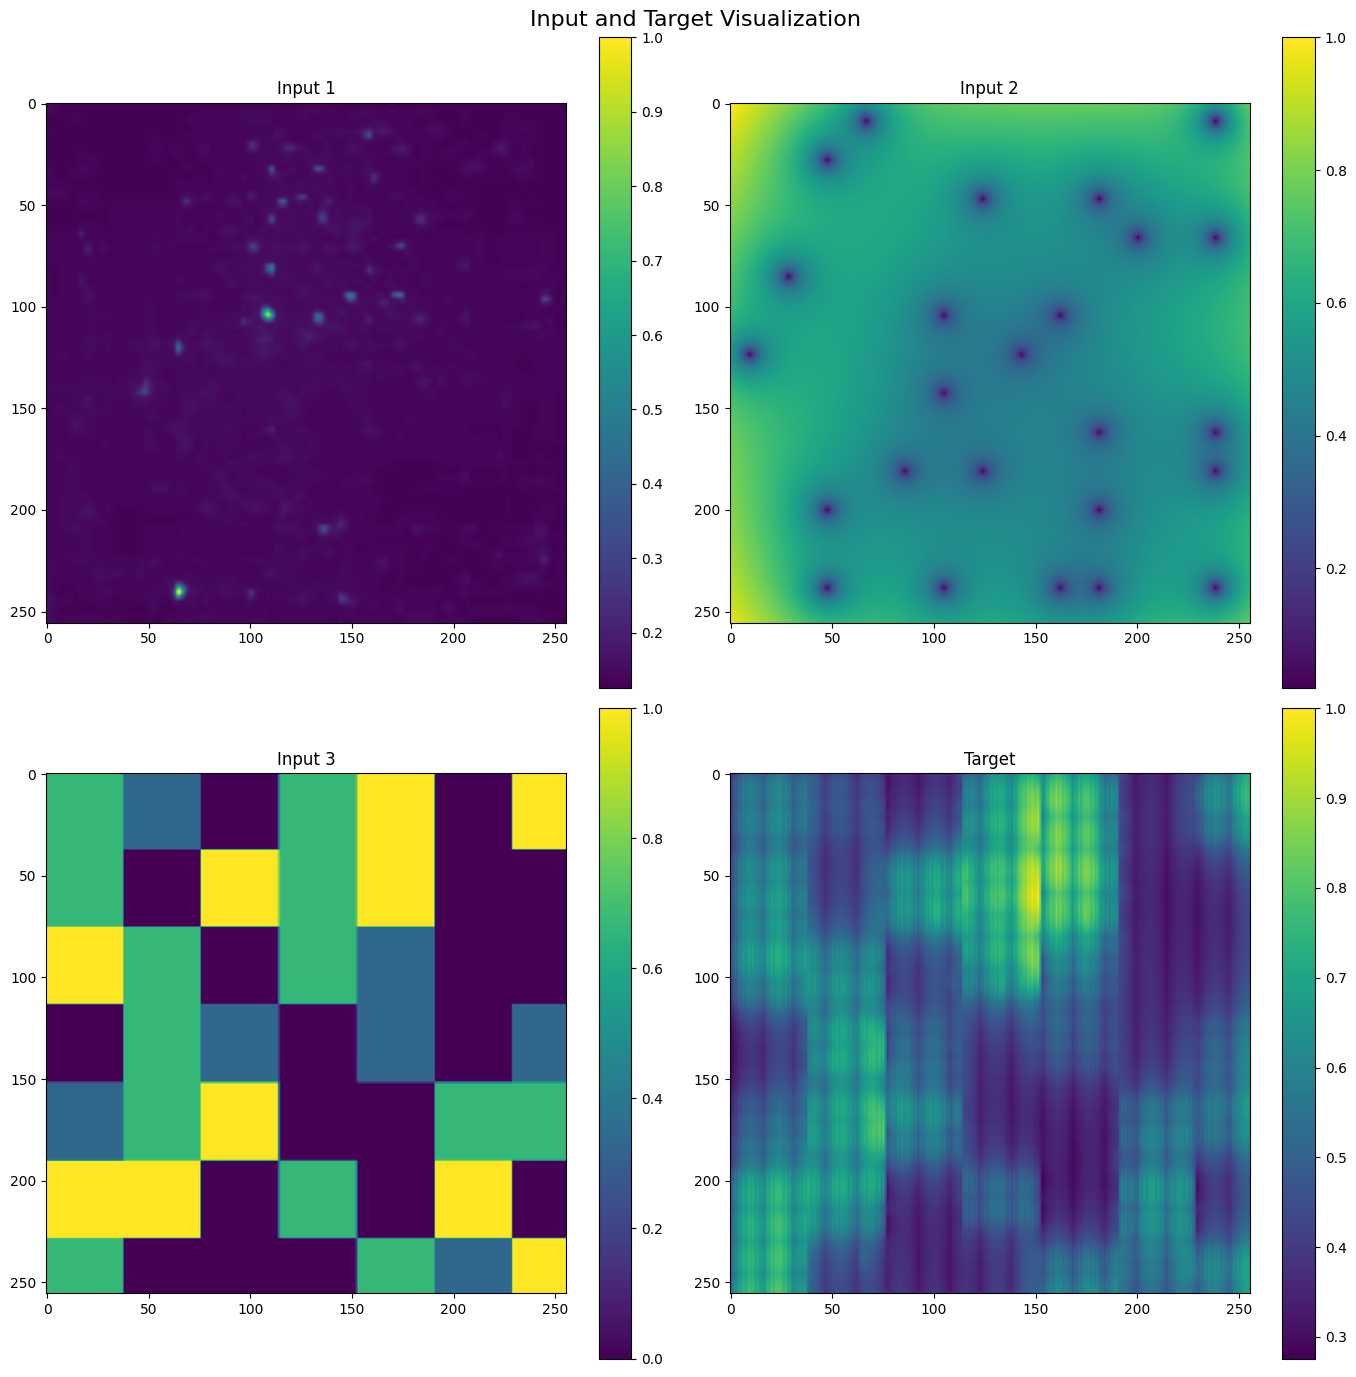

In [12]:
def visualize_data(inp, target, titles=None):
    """
    Visualize input and target tensors in a 2x2 subplot with colorbars.
    
    Args:
    inp (torch.Tensor): Input tensor of shape (3, 256, 256)
    target (torch.Tensor): Target tensor of shape (1, 256, 256)
    titles (list): List of titles for each subplot. If None, default titles will be used.
    """
    if titles is None:
        titles = ['Input 1', 'Input 2', 'Input 3', 'Target']
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 14))
    fig.suptitle('Input and Target Visualization', fontsize=16)
    
    # Flatten axs for easy iteration
    axs = axs.flatten()
    
    # Visualize each input channel and the target
    for i in range(3):
        im = axs[i].imshow(inp[i].cpu().numpy(), cmap='viridis')
        axs[i].set_title(titles[i])
        fig.colorbar(im, ax=axs[i])
    
    # Visualize the target
    im = axs[3].imshow(target[0].cpu().numpy(), cmap='viridis')
    axs[3].set_title(titles[3])
    fig.colorbar(im, ax=axs[3])
    
    plt.tight_layout()
    plt.show()

visualize_data(inp,target)    

In [13]:
def get_pred(model,inp):
    model.eval()
    with torch.no_grad():
        pred = model(inp.unsqueeze(0).to('cuda'))
    return pred.squeeze(0).squeeze(0)

In [14]:
pred = get_pred(model,inp)
pred.shape

torch.Size([256, 256])

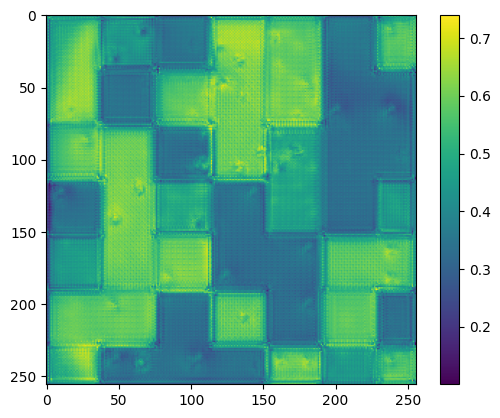

In [15]:
plt.imshow(pred.cpu().numpy())
plt.colorbar()

### cal mean, std

In [ ]:
from dataset import CustomDataset

def calculate_mean_std(dataset, batch_size=32, num_workers=4):
    """
    데이터셋의 평균과 표준편차를 계산합니다.
    
    Args:
    dataset (CustomDataset): 계산할 데이터셋
    batch_size (int): 데이터 로더의 배치 크기
    num_workers (int): 데이터 로딩에 사용할 워커 수
    
    Returns:
    tuple: (input_means, input_stds, target_mean, target_std)
    """
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    
    input_means = torch.zeros(3)
    input_stds = torch.zeros(3)
    target_mean = 0.
    target_std = 0.
    total_samples = 0

    for inputs, targets in tqdm(loader, desc="Calculating mean and std"):
        batch_samples = inputs.size(0)
        total_samples += batch_samples

        # 입력 데이터 처리 (3개의 1채널 행렬)
        for i in range(3):
            input_channel = inputs[:, i, :, :]
            input_means[i] += input_channel.mean().item() * batch_samples
            input_stds[i] += input_channel.std().item() * batch_samples

        # 타겟 데이터 처리
        target_mean += targets.mean().item() * batch_samples
        target_std += targets.std().item() * batch_samples

    input_means /= total_samples
    input_stds /= total_samples
    target_mean /= total_samples
    target_std /= total_samples

    return input_means, input_stds, target_mean, target_std

# 사용 예시:
dataset = CustomDataset(r'F:\NowWorking\Job_IR\data\BeGAN-circuit-benchmarks\nangate45\set1\data')
input_means, input_stds, target_mean, target_std = calculate_mean_std(dataset)
print(f"Input - Means: {input_means}, Stds: {input_stds}")
print(f"Target - Mean: {target_mean}, Std: {target_std}")

Calculating mean and std: 100%|██████████| 32/32 [01:55<00:00,  3.60s/it]

Input - Means: tensor([6.2446e-08, 1.4142e+01, 1.4631e+00]), Stds: tensor([4.9318e-08, 7.2629e+00, 1.1194e+00])
Target - Mean: 0.0011250363299623132, Std: 0.0004092390644364059


In [ ]:
class NormalizeTransform:
    def __init__(self, input_means, input_stds, target_mean, target_std):
        self.input_means = input_means
        self.input_stds = input_stds
        self.target_mean = target_mean
        self.target_std = target_std

    def __call__(self, input_data, target):
        normalized_input = (input_data - self.input_means[:, None, None]) / self.input_stds[:, None, None]
        normalized_target = (target - self.target_mean) / self.target_std
        return normalized_input, normalized_target
    
transform = NormalizeTransform(input_means,input_stds,target_mean,target_std)

transform(inp,target)

(tensor([[[-0.3651, -0.3651, -0.3662,  ..., -0.4773, -0.4773, -0.4773],
          [-0.3687, -0.3687, -0.3769,  ..., -0.4773, -0.4773, -0.4773],
          [-0.3735, -0.3735, -0.3911,  ..., -0.4773, -0.4773, -0.4773],
          ...,
          [-0.3434, -0.3434, -0.3762,  ..., -0.5148, -0.5148, -0.5148],
          [-0.3387, -0.3387, -0.3622,  ..., -0.5148, -0.5148, -0.5148],
          [-0.3387, -0.3387, -0.3622,  ..., -0.5148, -0.5148, -0.5148]],
 
         [[ 0.4907,  0.4762,  0.4616,  ..., -0.1239, -0.0928, -0.0627],
          [ 0.4798,  0.4652,  0.4505,  ..., -0.1461, -0.1135, -0.0821],
          [ 0.4690,  0.4543,  0.4396,  ..., -0.1672, -0.1331, -0.1005],
          ...,
          [ 0.3798,  0.3645,  0.3491,  ..., -0.1740, -0.1531, -0.1324],
          [ 0.3897,  0.3745,  0.3592,  ..., -0.1536, -0.1336, -0.1137],
          [ 0.3997,  0.3846,  0.3694,  ..., -0.1332, -0.1141, -0.0950]],
 
         [[ 0.4796,  0.4796,  0.4796,  ...,  1.3729,  1.3729,  1.3729],
          [ 0.4796,  0.4796,

In [ ]:
target

tensor([[[0.0005, 0.0005, 0.0006,  ..., 0.0009, 0.0009, 0.0009],
         [0.0005, 0.0005, 0.0006,  ..., 0.0010, 0.0010, 0.0010],
         [0.0005, 0.0006, 0.0006,  ..., 0.0010, 0.0010, 0.0010],
         ...,
         [0.0007, 0.0008, 0.0009,  ..., 0.0009, 0.0009, 0.0009],
         [0.0007, 0.0008, 0.0009,  ..., 0.0009, 0.0009, 0.0009],
         [0.0007, 0.0008, 0.0009,  ..., 0.0009, 0.0009, 0.0009]]])